# NeuralCompression Metrics Example

## Introduction

Welcome! This notebook will walkthrough using the `neuralcompression.metrics` and `torchmetrics` packages to evaluate models using rate distortion curves. 

First, if you haven't yet installed `neuralcompression`, do so below with: 

In [ ]:
!pip install git+https://github.com/facebookresearch/NeuralCompression/

In [1]:
from collections import defaultdict
import io

import torch
from torch.utils.data import DataLoader

from compressai import zoo

import torchmetrics as tm
import torchmetrics.functional as tmF

import neuralcompression as nc
import neuralcompression.functional as ncF
import neuralcompression.metrics as ncm

import torchvision.transforms as tfms

from tqdm import tqdm

import math
from PIL import Image

import matplotlib.pyplot as plt

## Finding And Using Metrics

The metrics implemented in `neuralcompression.metrics` aim to complement/extend those aready in `torchmetrics`. `torchmetrics` features high-quality implementations of MSE, PSNR, FID, KID, and more (check the [package documentation](https://torchmetrics.readthedocs.io/en/latest/references/modules.html) for a complete list), and are therefore not reimplemented inside of `neuralcompression`. 

Most of the metrics supported in `torchmetrics` have both functional and `nn.Module`-based APIs. Module metrics add additional functionality like accumulation across batches and first-class [compatibility](https://torchmetrics.readthedocs.io/en/latest/pages/lightning.html) with PyTorch Lightning.

In [2]:
image_shape = (1,3,256,256)

image_a = torch.randn(image_shape)
image_b = torch.randn(image_shape)

In [3]:
psnr_metric = tm.PSNR()
psnr_module = psnr_metric(image_a, image_b)
psnr_functional = tmF.psnr(image_a, image_b)

psnr_module, psnr_functional

(tensor(15.3505), tensor(15.3505))

Metrics that are missing from `torchmetrics` that are otherwise important to compression, such as MS-SSIM and LPIPS, can be found in `neuralcompression`. Similar to `torchmetrics`, each metric has a functional API that can be imported from `neuralcompression.functional`, and a Module API found in `neuralcompression.metrics`.

In [4]:
ms_ssim_metric = ncm.MultiscaleStructuralSimilarity()

ms_ssim_module = ms_ssim_metric(image_a, image_b)
ms_ssim_functional = ncF.multiscale_structural_similarity(image_a, image_b)

ms_ssim_module, ms_ssim_functional

(tensor(0.0042), tensor(0.0042))

Module-based metrics in `neuralcompression` are instances of `torchmetrics.Metric`, so they are fully compatible with other `torchmetrics` features, like metric collections.

In [5]:
# Using metrics from both torchmetrics and neuralcompression
collection = tm.MetricCollection(
    psnr_metric,
    ms_ssim_metric
)

collection(image_a, image_b)

{'PSNR': tensor(15.3505), 'MultiscaleStructuralSimilarity': tensor(0.0042)}

## Calculating Rate-Distortion Curves

We'll now go through an example of calculating rate-distortion curves for the [scale hyperprior model](https://arxiv.org/abs/1802.01436) on the [Kodak dataset](http://www.cs.albany.edu/~xypan/research/snr/Kodak.html), comparing it to the non-ML image codec JPEG.

In [6]:
def make_jpeg_rd_curve(dataloader, metrics: tm.MetricCollection):
        
    rd_curve = []
    to_PIL = tfms.ToPILImage()
    to_tensor = tfms.ToTensor()
    
    for quality in tqdm(range(0, 91, 10)):
        
        bpp_sum = 0.0
        metrics_sum = defaultdict(lambda: 0.0)
        
        for img in dataloader:
            pil_image = to_PIL(img.squeeze(0))
            buffer = io.BytesIO()
            pil_image.save(buffer, format="JPEG", quality=quality)
            
            bits = len(buffer.getvalue()) * 8
            bpp = bits / (img.shape[2] * img.shape[3])
            
            bpp_sum += bpp
            
            reconstruction = to_tensor(Image.open(buffer, formats=["JPEG"])).unsqueeze(0)
            
            distortions = metrics(img, reconstruction)
            for k,v in distortions.items():
                metrics_sum[k] += v
        
        average_metrics = {k: v / len(dataloader) for k,v in metrics_sum.items()}
        average_bpp = bpp_sum / len(dataloader)
        
        rd_curve.append((average_bpp, average_metrics))
    
    return rd_curve

def make_scale_hyperprior_rd_curve(dataloader, metrics: tm.MetricCollection):
    rd_curve = []
    to_tensor = tfms.ToTensor()
        
    for quality in tqdm(range(1, 9)):
        
        bpp_sum = 0.0
        metrics_sum = defaultdict(lambda: 0.0)
        
        model = zoo.bmshj2018_hyperprior(quality=quality, pretrained=True)
        model.eval()
        model.update()
        with torch.no_grad():
            for img in dataloader:         
                compressed = model.compress(img)
                bits = 0.0
                for string_list in compressed["strings"]: # strings for image + hyper latent
                    for string in string_list: # iterating over batch
                        bits += len(string) * 8

                bpp = bits / (img.shape[0] * img.shape[2] * img.shape[3])

                bpp_sum += bpp

                reconstruction = model.decompress(**compressed)["x_hat"]
                distortions = metrics(img, reconstruction)
                for k,v in distortions.items():
                    metrics_sum[k] += v

            average_metrics = {k: v / len(dataloader) for k,v in metrics_sum.items()}
            average_bpp = bpp_sum / len(dataloader)
            rd_curve.append((average_bpp, average_metrics))
        
        del model
    
    return rd_curve

In [7]:
# Pass download=True if dataset doesn't exist already
ds = nc.data.Kodak("kodak", transform = tfms.ToTensor())
dl = DataLoader(ds, batch_size = 1)
metrics = tm.MetricCollection(
    tm.PSNR(), 
    tm.MeanSquaredError(), 
    ncm.MultiscaleStructuralSimilarity()
)

In [8]:
jpeg_curve = make_jpeg_rd_curve(dl, metrics)

100%|██████████| 10/10 [01:30<00:00,  9.03s/it]


In [9]:
shp_curve = make_scale_hyperprior_rd_curve(dl, metrics)

100%|██████████| 8/8 [03:27<00:00, 25.95s/it]


## Plotting the Results

In [10]:
def plot_rd_curve(names_to_rd_curves, metric_name, y_label = None, y_transform = None):       
    plot = plt.axes()

    plot.set_title(f"{metric_name} vs bits-per-pixel")
    plot.set_xlabel("bits per pixel")
    
    if y_label is None:
        plot.set_ylabel(metric_name)
    else:
        plot.set_ylabel(y_label)
        
    for codec_name, curve in names_to_rd_curves.items():
        x_data = [data[0] for data in curve]
        y_data = [data[1][metric_name] for data in curve]
            
        if y_transform is not None:
            y_data = [y_transform(y) for y in y_data]
        
        line, = plot.plot(x_data, y_data)
        line.set_label(codec_name)

    plot.grid()
    plot.legend()
    
    return plot

In [11]:
curve_dict = {"JPEG": jpeg_curve, "Scale Hyperprior": shp_curve}

<AxesSubplot:title={'center':'PSNR vs bits-per-pixel'}, xlabel='bits per pixel', ylabel='PSNR'>

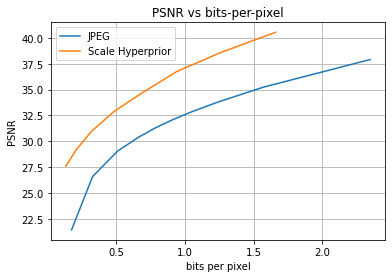

In [12]:
plot_rd_curve(curve_dict, "PSNR")

<AxesSubplot:title={'center':'MeanSquaredError vs bits-per-pixel'}, xlabel='bits per pixel', ylabel='MeanSquaredError'>

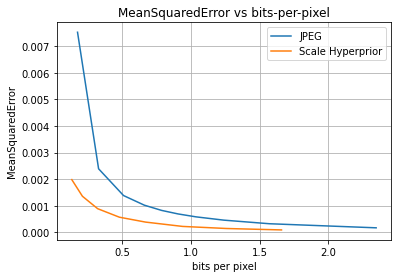

In [13]:
plot_rd_curve(curve_dict, "MeanSquaredError")

<AxesSubplot:title={'center':'MultiscaleStructuralSimilarity vs bits-per-pixel'}, xlabel='bits per pixel', ylabel='MS-SSIM (dB)'>

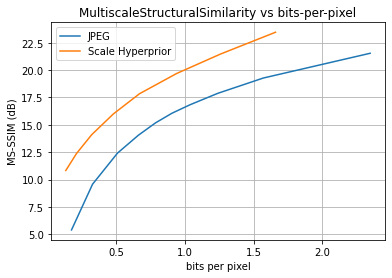

In [14]:
# Plotting MS-SSIM in dB as is done in the Scale Hyperprior paper.
plot_rd_curve(
    curve_dict, 
    "MultiscaleStructuralSimilarity", 
    y_transform = lambda d: -10*math.log10(1 - d), 
    y_label = "MS-SSIM (dB)"
)

# Conclusion

Check out the [torchmetrics documentation](https://torchmetrics.readthedocs.io/en/latest/) for more details on metric features like syncing state across processes and compatability with PyTorch Lightning.